In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import seaborn as sns     #seaborn画出的图更好看，且代码更简单，缺点是可塑性差
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from torch.autograd import Variable
from sklearn import metrics


In [2]:
data = pd.read_csv('./Data/datafull.csv',index_col= 'time')

定义滑动窗口

In [3]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length),:]
        _y = [data[i+seq_length,0]]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

以PM2.5为例子

In [4]:
df =  pd.DataFrame(data[['NO2']])

<AxesSubplot:xlabel='time'>

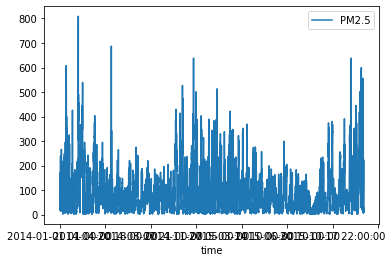

In [5]:
df.plot()

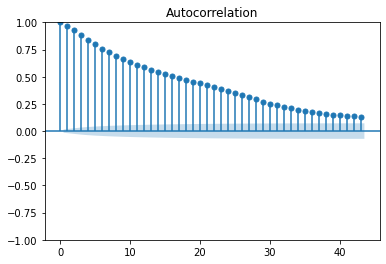

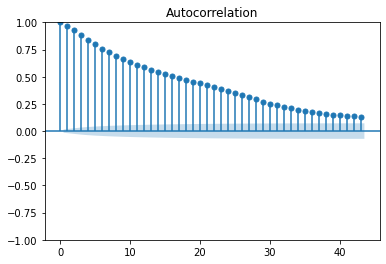

In [6]:
plot_acf(df)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
sc = StandardScaler()
sc.fit(df)
training_data = sc.transform(df)
#training_data = sc.fit_transform(df)

seq_length = 8
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.9)
test_size = len(y) - train_size

dataX = (torch.Tensor(np.array(x)))
dataY = (torch.Tensor(np.array(y)))

trainX = (torch.Tensor(np.array(x[0:train_size])))
trainY = (torch.Tensor(np.array(y[0:train_size])))

testX = (torch.Tensor(np.array(x[train_size:len(x)])))
testY = (torch.Tensor(np.array(y[train_size:len(y)])))

定义model

In [7]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,device):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.device = device

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size, 128)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Propagate input through GRU
        _, h_out = self.gru(x, h_0)
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc_1(h_out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [26]:
num_epochs = 2000
learning_rate = 0.0005

input_size = 1
hidden_size = 256
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers,device)
gri = gru.to(device)

trainX = trainX.to(device)
trainY = trainY.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.93942
Epoch: 100, loss: 0.10397
Epoch: 200, loss: 0.10223
Epoch: 300, loss: 0.10255
Epoch: 400, loss: 0.10201
Epoch: 500, loss: 0.10405
Epoch: 600, loss: 0.10179
Epoch: 700, loss: 0.10168
Epoch: 800, loss: 0.10154
Epoch: 900, loss: 0.10146
Epoch: 1000, loss: 0.10137
Epoch: 1100, loss: 0.10135
Epoch: 1200, loss: 0.10123
Epoch: 1300, loss: 0.10109
Epoch: 1400, loss: 0.10113
Epoch: 1500, loss: 0.10090
Epoch: 1600, loss: 0.10076
Epoch: 1700, loss: 0.10062
Epoch: 1800, loss: 0.10043
Epoch: 1900, loss: 0.10019


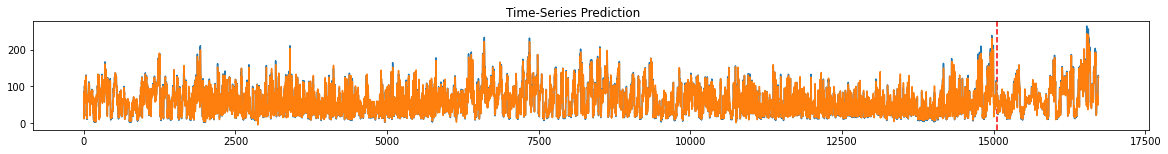

In [27]:
gru.eval()
train_predict = gru(dataX.to(device))

data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

#data_predict = data_predict*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
#dataY_plot = dataY*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
data_predict = data_predict*sc.scale_[0]+sc.mean_[0]
dataY_plot = dataY*sc.scale_[0]+sc.mean_[0]

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20, 2))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.suptitle('Time-Series Prediction')
plt.show()

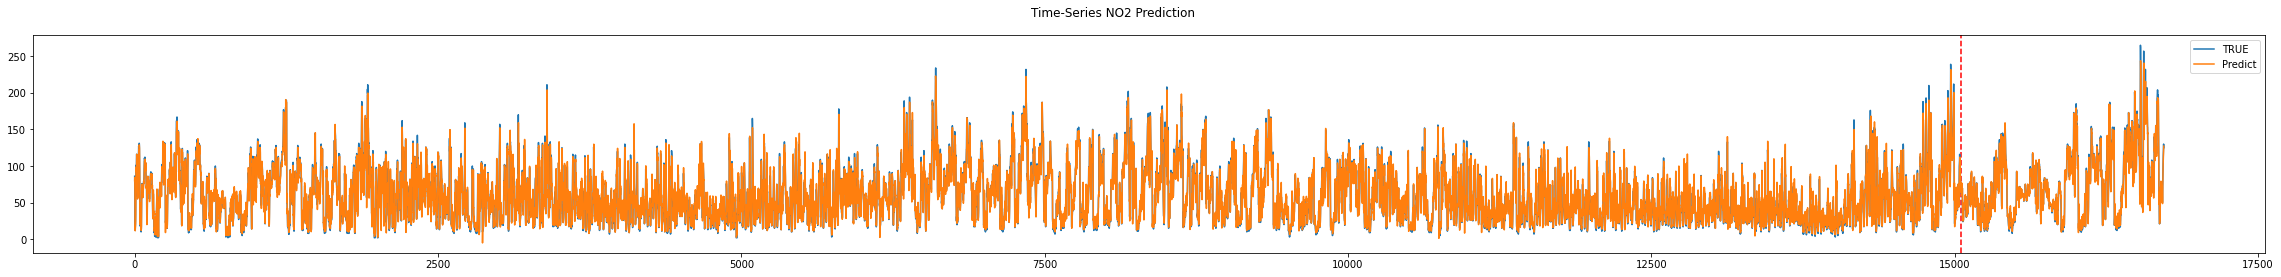

In [28]:
plt.figure(figsize=(40, 4))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_GRU_0.9.png')

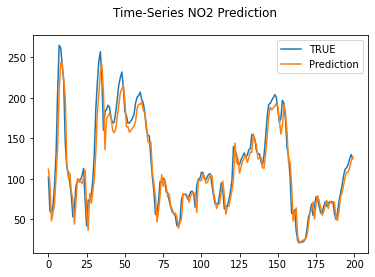

In [29]:
plt.plot(dataY_plot[-200:],label='TRUE')
plt.plot(data_predict[-200:],label='Prediction')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_GRU_0.9_2.png')

In [31]:
metrics.mean_squared_error(dataY_plot,data_predict)**0.5

11.77376992832777

滚动预测

In [14]:
# 先预测后一个值
for i in range(10):
    temp_X = training_data[-seq_length:,:]
    training_data =np.append(training_data,gru(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy(),axis=0)

In [15]:
sc.inverse_transform(training_data)[-10:]

array([[223.5455367 ],
       [219.62339571],
       [212.9775504 ],
       [204.83337372],
       [197.16006885],
       [191.52863271],
       [188.17809695],
       [186.44305   ],
       [185.51950712],
       [184.88952412]])

In [58]:
# 多元
df = pd.DataFrame(data[['NO2','TEMP','PRES','RAIN','HUMI','EWS','NWS']])
sc = StandardScaler()
sc.fit(df)
training_data = sc.transform(df)
#training_data = sc.fit_transform(df)

seq_length = 8
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) *0.9)
test_size = len(y) - train_size

dataX = (torch.Tensor(np.array(x)))
dataY = (torch.Tensor(np.array(y)))

trainX = (torch.Tensor(np.array(x[0:train_size])))
trainY = (torch.Tensor(np.array(y[0:train_size])))

testX = (torch.Tensor(np.array(x[train_size:len(x)])))
testY = (torch.Tensor(np.array(y[train_size:len(y)])))
num_epochs = 2000
learning_rate = 0.0005

input_size = 7
hidden_size = 256
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers,device)
gru = gru.to(device)

trainX = trainX.to(device)
trainY = trainY.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
#metrics.mean_squared_error(dataY_plot,data_predict)**0.5
# 先预测后一个值


Epoch: 0, loss: 0.94922
Epoch: 100, loss: 0.09242
Epoch: 200, loss: 0.08763
Epoch: 300, loss: 0.08515
Epoch: 400, loss: 0.08333
Epoch: 500, loss: 0.08188
Epoch: 600, loss: 0.08080
Epoch: 700, loss: 0.08316
Epoch: 800, loss: 0.07732
Epoch: 900, loss: 0.07563
Epoch: 1000, loss: 0.07378
Epoch: 1100, loss: 0.07173
Epoch: 1200, loss: 0.06939
Epoch: 1300, loss: 0.06636
Epoch: 1400, loss: 0.06364
Epoch: 1500, loss: 0.05946
Epoch: 1600, loss: 0.05558
Epoch: 1700, loss: 0.05042
Epoch: 1800, loss: 0.04554
Epoch: 1900, loss: 0.04067


Text(0.5, 0.98, 'Time-Series Prediction')

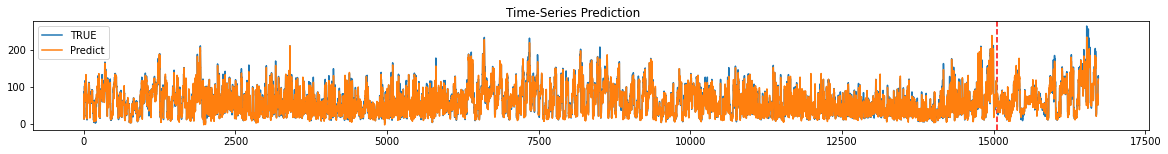

In [59]:
gru.eval()
train_predict = gru(dataX.to(device))

data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

#data_predict = data_predict*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
#dataY_plot = dataY*(sc.data_max_[0]-sc.data_min_[0])+sc.data_min_[0]
data_predict = data_predict*sc.scale_[0]+sc.mean_[0]
dataY_plot = dataY*sc.scale_[0]+sc.mean_[0]

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20, 2))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series Prediction')


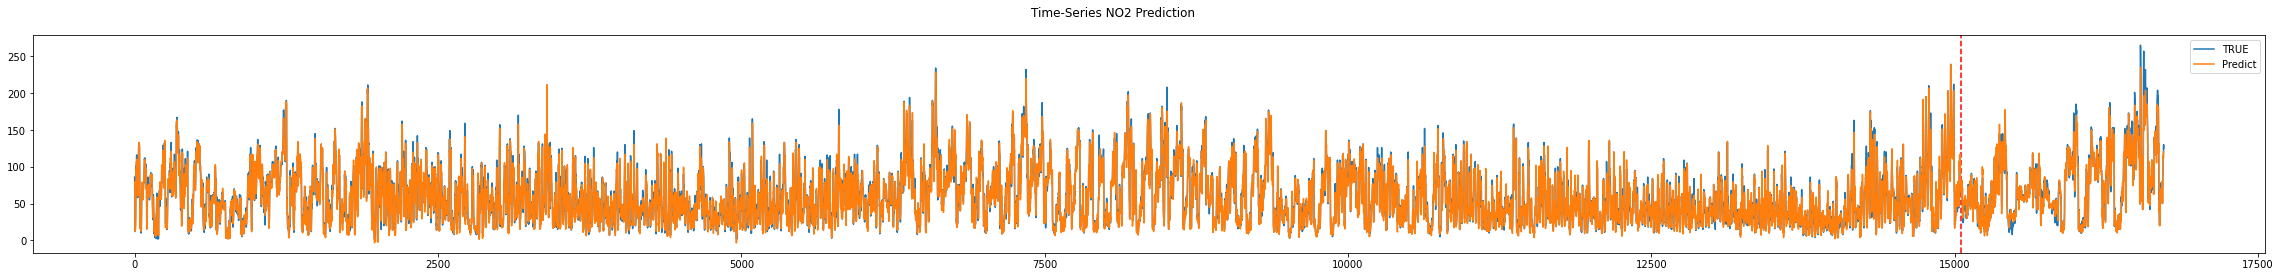

In [60]:
plt.figure(figsize=(40, 4))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot,label='TRUE')
plt.plot(data_predict,label = 'Predict')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_GRU_multi_0.9.png')

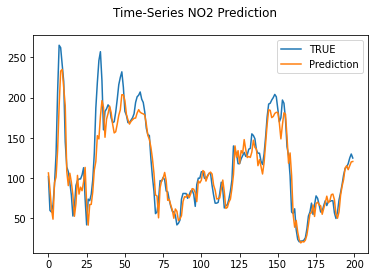

In [61]:
plt.plot(dataY_plot[-200:],label='TRUE')
plt.plot(data_predict[-200:],label='Prediction')
plt.legend()
plt.suptitle('Time-Series NO2 Prediction')
plt.savefig('./figure/NO2_Predict_GRU_multi_0.9_2.png')

In [53]:
metrics.mean_squared_error(dataY_plot,data_predict)**0.5

8.496574160268214

In [16]:
data1 = pd.read_csv('./Data/datafull.csv',index_col='time')

In [17]:
for i in range(10):
    data1.loc[len(data1)] = 0
    data1.index= data1.index[:-2].append(pd.date_range(data1.index[-2],periods=2,freq='H'))

In [18]:
data1.drop(columns=['WD', 'WS'],inplace= True)

In [19]:
for names in data1.columns:
    df = pd.DataFrame(data[[names]])
    sc = StandardScaler()
    sc.fit(df)
    training_data = sc.transform(df)
    #training_data = sc.fit_transform(df)

    seq_length = 8
    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) *1)
    test_size = len(y) - train_size

    dataX = (torch.Tensor(np.array(x)))
    dataY = (torch.Tensor(np.array(y)))

    trainX = (torch.Tensor(np.array(x[0:train_size])))
    trainY = (torch.Tensor(np.array(y[0:train_size])))

    testX = (torch.Tensor(np.array(x[train_size:len(x)])))
    testY = (torch.Tensor(np.array(y[train_size:len(y)])))
    num_epochs = 2000
    learning_rate = 0.0005

    input_size = 1
    hidden_size = 256
    num_layers = 1

    num_classes = 1

    gru = GRU(num_classes, input_size, hidden_size, num_layers,device)
    gru = gru.to(device)

    trainX = trainX.to(device)
    trainY = trainY.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = gru(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    metrics.mean_squared_error(dataY_plot,data_predict)**0.5
    # 先预测后一个值
    for i in range(10):
        temp_X = training_data[-seq_length:,:]
        training_data =np.append(training_data,gru(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy(),axis=0)
    predict = sc.inverse_transform(training_data)[-10:]
    data1[names][-10:] = predict[-10:,0]

Epoch: 0, loss: 0.97060
Epoch: 100, loss: 0.06300
Epoch: 200, loss: 0.05555
Epoch: 300, loss: 0.05481
Epoch: 400, loss: 0.05494
Epoch: 500, loss: 0.05430
Epoch: 600, loss: 0.05409
Epoch: 700, loss: 0.05393
Epoch: 800, loss: 0.05379
Epoch: 900, loss: 0.05363
Epoch: 1000, loss: 0.05345
Epoch: 1100, loss: 0.05333
Epoch: 1200, loss: 0.05301
Epoch: 1300, loss: 0.05275
Epoch: 1400, loss: 0.05264
Epoch: 1500, loss: 0.05227
Epoch: 1600, loss: 0.05184
Epoch: 1700, loss: 0.05145
Epoch: 1800, loss: 0.05092
Epoch: 1900, loss: 0.05050
Epoch: 0, loss: 1.01363
Epoch: 100, loss: 0.10980
Epoch: 200, loss: 0.10472
Epoch: 300, loss: 0.10310
Epoch: 400, loss: 0.10237
Epoch: 500, loss: 0.10222
Epoch: 600, loss: 0.10154
Epoch: 700, loss: 0.10103
Epoch: 800, loss: 0.10068
Epoch: 900, loss: 0.09981
Epoch: 1000, loss: 0.09909
Epoch: 1100, loss: 0.09815
Epoch: 1200, loss: 0.09703
Epoch: 1300, loss: 0.09562
Epoch: 1400, loss: 0.09393
Epoch: 1500, loss: 0.09283
Epoch: 1600, loss: 0.09183
Epoch: 1700, loss: 0.0909

In [20]:
data1.to_csv('./Data/gru_single.csv')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

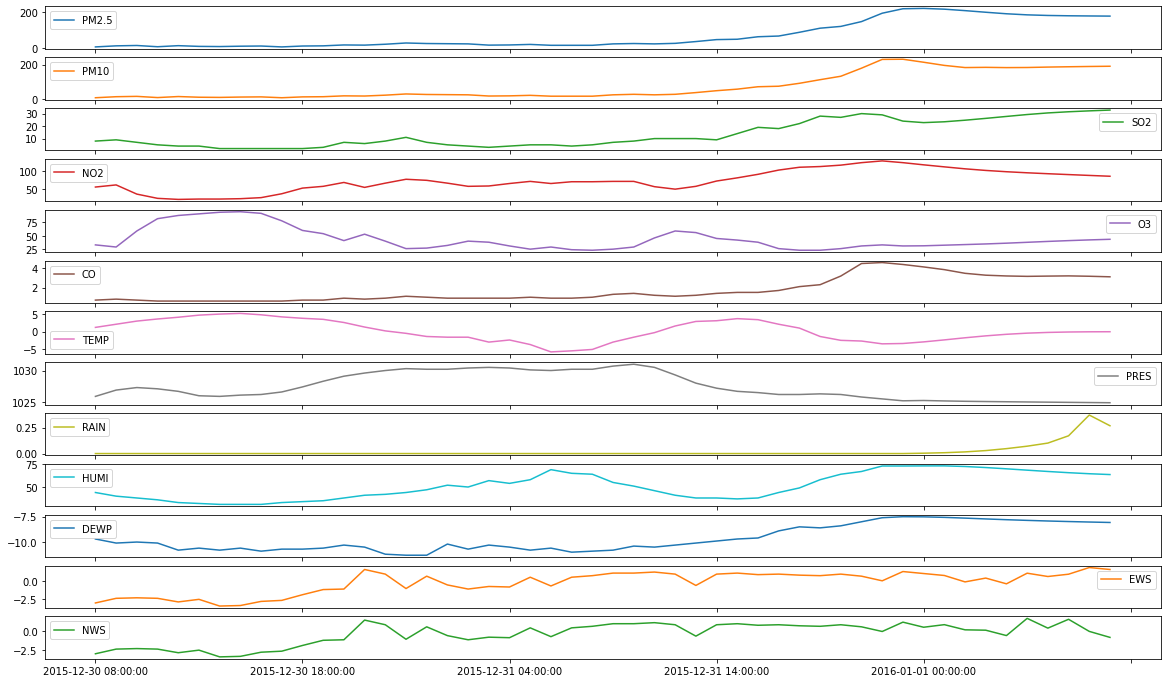

In [21]:
data1.iloc[-50:].plot(subplots = True,figsize = (20,12))

COV

In [6]:
data1 = pd.read_csv('./Data/gru_single.csv',index_col=0)

In [7]:
data2 = pd.read_csv('./Data/datafull.csv',index_col='time')

In [8]:
for i in range(10):
    data2.loc[len(data2)] = 0
    data2.index= data2.index[:-2].append(pd.date_range(data2.index[-2],periods=2,freq='H'))

In [9]:
data2.drop(columns=['WD', 'WS','DEWP','TEMP','PRES','RAIN','HUMI','EWS','NWS'],inplace= True)

In [12]:
for names in data2.columns:
    df = pd.DataFrame(data1[[names,'TEMP','PRES','RAIN','HUMI','EWS','NWS']])
    sc = StandardScaler()
    sc.fit(df)
    training_data = sc.transform(df)
    #training_data = sc.fit_transform(df)

    seq_length = 8
    x, y = sliding_windows(training_data, seq_length)

    train_size = int(len(y) *1)
    test_size = len(y) - train_size

    dataX = (torch.Tensor(np.array(x)))
    dataY = (torch.Tensor(np.array(y)))

    trainX = (torch.Tensor(np.array(x[0:-10])))
    trainY = (torch.Tensor(np.array(y[0:-10])))

    testX = (torch.Tensor(np.array(x[train_size:len(x)])))
    testY = (torch.Tensor(np.array(y[train_size:len(y)])))
    num_epochs = 2000
    learning_rate = 0.0005

    input_size = 7
    hidden_size = 256
    num_layers = 1

    num_classes = 1

    gru = GRU(num_classes, input_size, hidden_size, num_layers,device)
    gru = gru.to(device)

    trainX = trainX.to(device)
    trainY = trainY.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = gru(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    #metrics.mean_squared_error(dataY_plot,data_predict)**0.5
    # 先预测后一个值
    for i in range(10):
        temp_X = training_data[-seq_length:,:]
        training_data[len(data)+i,0] = gru(torch.Tensor(np.array([temp_X])).to(device)).cpu().data.numpy()
    predict = sc.inverse_transform(training_data)[-10:]
    data2[names][-10:] = predict[-10:,0]

Epoch: 0, loss: 1.00734
Epoch: 100, loss: 0.06172
Epoch: 200, loss: 0.04986
Epoch: 300, loss: 0.04793
Epoch: 400, loss: 0.04644
Epoch: 500, loss: 0.04546
Epoch: 600, loss: 0.04413
Epoch: 700, loss: 0.04316
Epoch: 800, loss: 0.04205
Epoch: 900, loss: 0.04138
Epoch: 1000, loss: 0.03980
Epoch: 1100, loss: 0.03866
Epoch: 1200, loss: 0.03754
Epoch: 1300, loss: 0.03644
Epoch: 1400, loss: 0.03515
Epoch: 1500, loss: 0.03395
Epoch: 1600, loss: 0.03257
Epoch: 1700, loss: 0.03142
Epoch: 1800, loss: 0.03049
Epoch: 1900, loss: 0.02854
Epoch: 0, loss: 1.01097
Epoch: 100, loss: 0.10389
Epoch: 200, loss: 0.09532
Epoch: 300, loss: 0.09304
Epoch: 400, loss: 0.09094
Epoch: 500, loss: 0.08870
Epoch: 600, loss: 0.08642
Epoch: 700, loss: 0.08711
Epoch: 800, loss: 0.08095
Epoch: 900, loss: 0.07751
Epoch: 1000, loss: 0.07337
Epoch: 1100, loss: 0.06890
Epoch: 1200, loss: 0.06374
Epoch: 1300, loss: 0.06058
Epoch: 1400, loss: 0.05548
Epoch: 1500, loss: 0.05132
Epoch: 1600, loss: 0.04737
Epoch: 1700, loss: 0.0441

In [13]:
data2.tail(11)

,PM2.5,PM10,SO2,NO2,O3,CO
2015-12-31 23:00:00,221.000000,231.000000,24.000000,125.000000,31.000000,4.400000
2016-01-01 00:00:00,190.330720,179.534765,34.904981,86.685008,42.810974,3.414336
2016-01-01 01:00:00,190.330720,179.534765,34.904981,86.685008,42.810974,3.414336
2016-01-01 02:00:00,190.330720,179.534765,34.904981,86.685008,42.810974,3.414336
2016-01-01 03:00:00,189.325982,179.193066,35.221785,85.890819,42.941509,3.416095
2016-01-01 04:00:00,189.247456,178.794091,35.217417,85.265042,43.059103,3.414699
2016-01-01 05:00:00,188.964375,178.775732,35.751367,85.443258,43.114367,3.411889
2016-01-01 06:00:00,189.068689,178.981578,34.766818,85.474945,43.095332,3.440542
2016-01-01 07:00:00,188.176694,180.683621,34.888223,85.841744,43.016629,3.363807
2016-01-01 08:00:00,188.996668,179.603997,35.806356,85.356645,42.866396,3.343113


In [14]:
data2.to_csv('./Data/gru_cov.csv')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

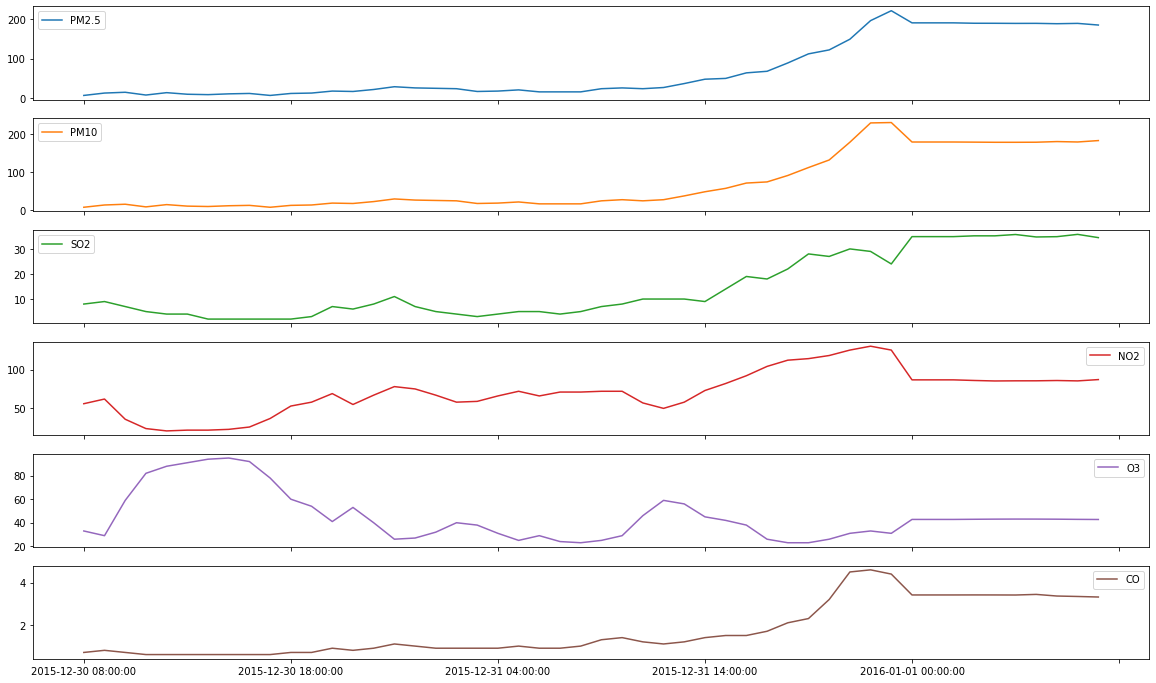

In [15]:
data2.iloc[-50:].plot(subplots = True,figsize = (20,12))